## Image Classification For the Apple Leaves

### Loading Modules and Setting up the parameters

In [1]:
# -----------------------------------
# GLOBAL FEATURE EXTRACTION
# -----------------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import cv2
import os
import h5py

# --------------------
# tunable-parameters
# --------------------
images_per_class = 800
fixed_size = tuple((500, 500))
train_path = "../dataset/train"
test_path = "../dataset/test"
h5_train_features = "../embeddings/features/features.h5"
h5_train_labels = "../embeddings/labels/labels.h5"
bins = 8

### BGR To RGB Conversion

In [2]:
# Converting each image to RGB from BGR format
def rgb_bgr(image):
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return rgb_img


### RGB to HSV (Hue Saturation Value) Conversion

In [3]:
# Conversion to HSV image format from RGB
def bgr_hsv(rgb_img):
    hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
    return hsv_img


### Image Segmentation

In [4]:
# for extraction of green and brown color


def img_segmentation(rgb_img, hsv_img):
    lower_green = np.array([25, 0, 20])
    upper_green = np.array([100, 255, 255])
    healthy_mask = cv2.inRange(hsv_img, lower_green, upper_green)
    result = cv2.bitwise_and(rgb_img, rgb_img, mask=healthy_mask)
    lower_brown = np.array([10, 0, 10])
    upper_brown = np.array([30, 255, 255])
    disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
    disease_result = cv2.bitwise_and(rgb_img, rgb_img, mask=disease_mask)
    final_mask = healthy_mask + disease_mask
    final_result = cv2.bitwise_and(rgb_img, rgb_img, mask=final_mask)
    return final_result

### Determining the feature descriptors

#### 1. Hu Moments

In [5]:
# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature


#### 2. Haralick Textures

In [6]:
# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick


#### 3. Color HIstogram

In [7]:
# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist(
        [image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256]
    )
    cv2.normalize(hist, hist)
    return hist.flatten()

### Loading up the training dataset

In [8]:
# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()
print(train_labels)

# empty lists to hold feature vectors and labels
global_features = []
labels = []

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy']


### Generating the Features and Label Embeddings from the dataset

In [9]:
# loop over the training data sub-folders
for training_name in train_labels:
    # join the training data path and each species training folder
    img_dir_path = os.path.join(train_path, training_name)

    # get the current training label
    current_label = training_name

    # loop over the images in each sub-folder
    for img in os.listdir(img_dir_path):
        # get the image file name
        file = os.path.join(img_dir_path, img)

        # read the image and resize it to a fixed-size
        image = cv2.imread(file)
        image = cv2.resize(image, fixed_size)

        # Running Function Bit By Bit
        RGB_BGR = rgb_bgr(image)
        BGR_HSV = bgr_hsv(RGB_BGR)
        IMG_SEGMENT = img_segmentation(RGB_BGR, BGR_HSV)

        # Call for Global Feature Descriptors
        fv_hu_moments = fd_hu_moments(IMG_SEGMENT)
        fv_haralick = fd_haralick(IMG_SEGMENT)
        fv_histogram = fd_histogram(IMG_SEGMENT)

        # Concatenate global features
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

        # update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)

    print("[STATUS] processed folder: {}".format(current_label))

print("[STATUS] completed Global Feature Extraction...")

[STATUS] processed folder: Apple___Apple_scab
[STATUS] processed folder: Apple___Black_rot
[STATUS] processed folder: Apple___Cedar_apple_rust
[STATUS] processed folder: Apple___healthy
[STATUS] completed Global Feature Extraction...


In [10]:
# print(global_features)

In [41]:
# get the overall feature vector size
print("[STATUS] feature vector size {}".format(np.array(global_features).shape))

[STATUS] feature vector size (3010, 532)


In [12]:
# get the overall training label size
# print(labels)
print("[STATUS] training Labels {}".format(np.array(labels).shape))


[STATUS] training Labels (3010,)


#### 1. Encoding the Labels
| Label                     | Encoded value |
| ------------------------- | --------------|
| Apple___Apple_scab        | 0             |
| Apple___Black_rot         | 1             |
| Apple___Cedar_apple_rust  | 2             |
| Apple___healthy           | 3             |

In [13]:
# encode the target labels
targetNames = np.unique(labels)
le = LabelEncoder()
target = le.fit_transform(labels)
print(targetNames)
print("[STATUS] training labels encoded...")

['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy']
[STATUS] training labels encoded...


#### 2. Feature Scaling Using MIn Max Scaler

In [14]:
# scale features in the range (0-1)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("[STATUS] feature vector normalized...")
rescaled_features

[STATUS] feature vector normalized...


array([[0.8974175 , 0.03450962, 0.01845123, ..., 0.02027887, 0.12693291,
        0.96573218],
       [0.89815922, 0.13025558, 0.02774864, ..., 0.02027767, 0.12692423,
        0.96573354],
       [0.56777027, 0.        , 0.01540143, ..., 0.02027886, 0.12693269,
        0.96573218],
       ...,
       [0.95697685, 0.01228793, 0.00548476, ..., 0.02027886, 0.12693346,
        0.96573218],
       [0.97704002, 0.10614054, 0.03136325, ..., 0.02027885, 0.12692424,
        0.96573217],
       [0.95214074, 0.03819411, 0.03671892, ..., 0.02027886, 0.12692996,
        0.96573217]])

In [42]:
print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))

[STATUS] target labels: [0 0 0 ... 3 3 3]
[STATUS] target labels shape: (3010,)


#### 3. Saving the Features and Labels Embeddings in h5py format

##### a. Features 

In [16]:
# save the feature vector using HDF5
h5f_data = h5py.File(h5_train_features, "w")
h5f_data.create_dataset("dataset_1", data=np.array(rescaled_features))

<HDF5 dataset "dataset_1": shape (3010, 532), type "<f8">

##### b. Labels

In [17]:
# save the label vector using HDF5
h5f_label = h5py.File(h5_train_labels, "w")
h5f_label.create_dataset("dataset_1", data=np.array(target))

<HDF5 dataset "dataset_1": shape (3010,), type "<i8">

In [43]:
h5f_data.close()
h5f_label.close()

### Evaluating the different models and calculating the accuracy

#### 1. Loading the Features and Labels Embeddings from the h5py format

In [37]:
# training
# -----------------------------------
# TRAINING OUR MODEL
# -----------------------------------
import h5py
import numpy as np
import os
import cv2
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import joblib

warnings.filterwarnings("ignore")

# --------------------
# tunable-parameters
# --------------------
num_trees = 100
test_size = 0.20
seed = 9
scoring = "accuracy"

# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()

if not os.path.exists(test_path):
    os.makedirs(test_path)

# create all the machine learning models
models = []
models.append(("LR", LogisticRegression(random_state=seed)))
models.append(("LDA", LinearDiscriminantAnalysis()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("DTC", DecisionTreeClassifier(random_state=seed)))
models.append(("RF", RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(("NB", GaussianNB()))
models.append(("SVM", SVC(random_state=seed)))

# variables to hold the results and names
results = []
names = []

# import the feature vector and trained labels
h5f_data = h5py.File(h5_train_features, "r")
h5f_label = h5py.File(h5_train_labels, "r")

global_features_string = h5f_data["dataset_1"]
global_labels_string = h5f_label["dataset_1"]

global_features = np.array(global_features_string)
global_labels = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")
print(global_labels, len(global_labels), len(global_features))

[STATUS] features shape: (3010, 532)
[STATUS] labels shape: (3010,)
[STATUS] training started...
[0 0 0 ... 3 3 3] 3010 3010


#### 2. Splitting the dataset into training and testing

In [38]:
# split the training and testing data
(
    trainDataGlobal,
    testDataGlobal,
    trainLabelsGlobal,
    testLabelsGlobal,
) = train_test_split(np.array(global_features), np.array(global_labels), test_size=test_size, random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))

[STATUS] splitted train and test data...
Train data  : (2408, 532)
Test data   : (602, 532)


In [40]:
trainDataGlobal

array([[9.47066972e-01, 1.97577832e-02, 5.34481987e-04, ...,
        2.02788613e-02, 1.26936845e-01, 9.65732178e-01],
       [9.67673181e-01, 4.20456024e-02, 5.76285634e-02, ...,
        2.02788294e-02, 1.26933581e-01, 9.65732217e-01],
       [9.84705756e-01, 2.97800312e-02, 1.34500344e-02, ...,
        2.02788553e-02, 1.26941878e-01, 9.65732187e-01],
       ...,
       [8.64347882e-01, 5.89053245e-02, 4.27430333e-02, ...,
        2.02791643e-02, 1.26961451e-01, 9.65733689e-01],
       [9.85818416e-01, 1.47428536e-03, 3.35008392e-03, ...,
        2.02767694e-02, 1.26792776e-01, 9.65732951e-01],
       [9.93152188e-01, 1.31020292e-03, 8.50637768e-04, ...,
        2.02910354e-02, 1.27475382e-01, 9.65721108e-01]])

#### 3. Evaluating the different models

In [22]:
# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(
        model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring
    )
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.900346 (0.020452)
LDA: 0.892038 (0.017931)
KNN: 0.884978 (0.019588)
CART: 0.886210 (0.014771)
RF: 0.967191 (0.012676)
NB: 0.839293 (0.014065)
SVM: 0.885813 (0.021190)


#### 4. Plotting the accuracy of the different models using matplotlib

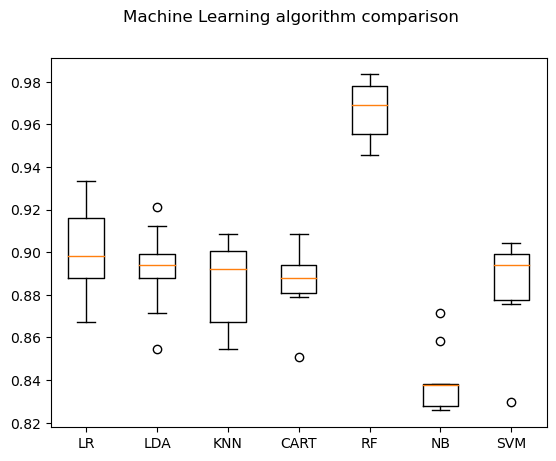

In [23]:
# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle("Machine Learning algorithm comparison")
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

From the above result we can see that the Random Forest Classifier model has the highest accuracy of 96.7% and the Gaussian NB model has the lowest accuracy of 83.9%

### Verifying the accuracy for the Random Forest Classifier Model

In [24]:
clf = RandomForestClassifier(n_estimators=num_trees, random_state=seed)

In [25]:
clf.fit(trainDataGlobal, trainLabelsGlobal)
len(trainDataGlobal), len(trainLabelsGlobal)

(2408, 2408)

In [34]:
y_predict = clf.predict(testDataGlobal)
testLabelsGlobal

array([3, 3, 1, 3, 0, 3, 1, 1, 2, 1, 1, 0, 1, 3, 3, 3, 3, 2, 0, 2, 0, 3,
       3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 1, 3, 3, 3, 2, 3, 1, 3, 3, 3,
       1, 0, 0, 3, 1, 3, 3, 0, 3, 3, 2, 3, 0, 3, 1, 0, 3, 0, 3, 3, 1, 3,
       3, 0, 3, 3, 0, 3, 3, 3, 3, 2, 1, 1, 2, 0, 2, 1, 1, 0, 0, 3, 2, 0,
       3, 2, 3, 3, 2, 3, 3, 1, 1, 3, 2, 0, 2, 1, 1, 2, 3, 3, 3, 1, 1, 0,
       3, 0, 3, 3, 0, 3, 3, 3, 1, 2, 3, 2, 3, 0, 3, 0, 3, 1, 3, 3, 3, 3,
       3, 2, 1, 0, 1, 3, 3, 3, 1, 3, 3, 0, 0, 3, 3, 3, 0, 2, 3, 3, 0, 1,
       1, 3, 0, 0, 3, 1, 3, 3, 1, 3, 2, 1, 0, 0, 3, 0, 1, 0, 1, 0, 1, 2,
       3, 3, 3, 3, 3, 2, 1, 1, 3, 3, 1, 3, 1, 3, 2, 1, 3, 3, 0, 3, 0, 3,
       3, 3, 1, 1, 3, 2, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3,
       3, 1, 1, 0, 3, 0, 3, 1, 3, 3, 3, 1, 3, 3, 0, 3, 0, 2, 3, 3, 0, 3,
       3, 3, 3, 0, 2, 3, 1, 3, 3, 3, 0, 3, 1, 3, 3, 3, 1, 3, 0, 2, 0, 3,
       3, 3, 2, 3, 3, 3, 0, 0, 1, 1, 3, 3, 0, 3, 2, 0, 1, 1, 3, 0, 3, 1,
       1, 3, 2, 2, 2, 3, 3, 3, 1, 1, 3, 0, 3, 0, 1,

In [27]:
y_predict

array([3, 3, 1, 3, 0, 3, 1, 1, 2, 1, 1, 3, 1, 3, 3, 3, 3, 2, 0, 2, 0, 3,
       3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 1, 3, 3, 3, 2, 3, 1, 3, 3, 3,
       1, 0, 0, 3, 1, 3, 3, 0, 3, 3, 2, 3, 0, 3, 1, 0, 3, 0, 3, 3, 1, 3,
       3, 0, 3, 3, 0, 3, 2, 3, 3, 2, 1, 1, 2, 3, 2, 1, 1, 0, 0, 3, 2, 0,
       3, 2, 3, 3, 2, 3, 3, 1, 1, 3, 2, 0, 2, 1, 1, 2, 3, 3, 3, 1, 1, 0,
       3, 0, 3, 3, 0, 3, 3, 3, 1, 2, 3, 2, 3, 0, 3, 0, 3, 1, 3, 0, 3, 3,
       0, 2, 1, 0, 1, 3, 3, 3, 1, 3, 3, 0, 0, 3, 3, 3, 0, 2, 3, 1, 0, 1,
       1, 3, 0, 0, 3, 1, 3, 3, 1, 3, 2, 1, 0, 0, 3, 0, 1, 0, 1, 0, 1, 2,
       3, 3, 3, 3, 3, 2, 1, 1, 3, 3, 1, 3, 1, 3, 2, 1, 3, 3, 0, 3, 0, 3,
       3, 3, 1, 1, 3, 2, 3, 0, 3, 3, 3, 0, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3,
       3, 1, 1, 0, 3, 0, 3, 1, 3, 3, 3, 1, 3, 3, 0, 3, 0, 2, 3, 3, 0, 3,
       3, 3, 3, 0, 2, 3, 1, 3, 3, 3, 0, 3, 1, 3, 3, 3, 1, 3, 0, 2, 0, 3,
       3, 3, 2, 3, 3, 3, 0, 0, 1, 1, 3, 3, 0, 3, 2, 0, 1, 1, 3, 0, 3, 1,
       1, 3, 2, 2, 2, 3, 3, 3, 1, 1, 3, 0, 3, 0, 1,

### Confusion Matrix For RFC Model

In [28]:
cm = confusion_matrix(testLabelsGlobal, y_predict)
cm

array([[112,   1,   0,   7],
       [  0, 114,   0,   3],
       [  0,   0,  48,   0],
       [  5,   1,   1, 310]], dtype=int64)

### Heat Map

<Axes: >

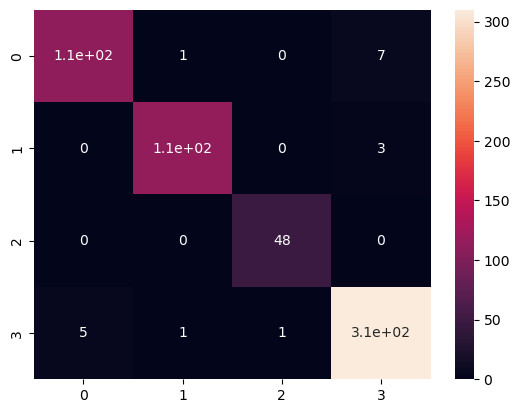

In [29]:
import seaborn as sns

sns.heatmap(cm, annot=True)

### Classification Report

In [30]:
print(classification_report(testLabelsGlobal, y_predict))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       120
           1       0.98      0.97      0.98       117
           2       0.98      1.00      0.99        48
           3       0.97      0.98      0.97       317

    accuracy                           0.97       602
   macro avg       0.97      0.97      0.97       602
weighted avg       0.97      0.97      0.97       602



### Accuracy Score

In [31]:
from sklearn.metrics import accuracy_score

In [32]:
accuracy_score(testLabelsGlobal, y_predict)

0.9700996677740864